# CQF - Final Project

## Optimal Hedging with Advanced Greeks

### Imports

In [1]:
import pandas as pd
import numpy as np
import math
import random
from itertools import accumulate
from scipy.stats import norm
from statistics import mean
from scipy.stats.mstats import gmean
from scipy.stats import qmc
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

### Equity prices evolution using Monte-Carlo

In order to generate equity prices paths we will use Monte-Carlo through the Geometric Brownian Motion (GBM). This means that the stock price follows a random walk and is consistent with the weak form of the efficient market hypothesis (EMH) - past price information is already incorporated, and the next price movement is "conditionally independent" of past price movements.

The formula for GBM is found below:

$$
\Delta S = S \mu \delta t + S \sigma \epsilon \sqrt{\Delta t}
$$

**where:**

$$
\begin{align*}
S &= \text{the stock price} \\
\Delta S &= \text{the change in stock price} \\
\mu &= \text{the expected return} \\
\sigma &= \text{the standard deviation of returns} \\
\epsilon &= \text{the random variable} \\
\Delta t &= \text{the elapsed time period} \\
\end{align*}
$$

We can use different ways for implement equity prices evolution computationally and we will discuss some of them as follow

#### Euler-Maruyama scheme

The Euler-Maruyama is a method for the approximate numerical solution of a stochastic differential equation (SDE).

$$
S_{n+1} = S_{n} + S_{n}r\Delta t + S_{n}\sigma \Delta B(t) \sqrt{\Delta t}
$$

where:
$$
\begin{align*}
S_0 &= \alpha \\
\end{align*}
$$

In [6]:
def euler_maruyama_scheme(S0, r, dt, sigma, B):
    """ the function returns the asset price evolution according to euler-maruyama scheme
    
    Keyword arguments:
    S0 -- the price of equity on time t0
    r -- the expected return
    dt -- the slice of time
    sigma -- the standard deviation of returns
    dB -- an array of random variables according to wiener process
    """
    return list(accumulate(B, lambda S,db: S + r*S*dt + sigma*S*db*np.sqrt(dt), initial=S0))

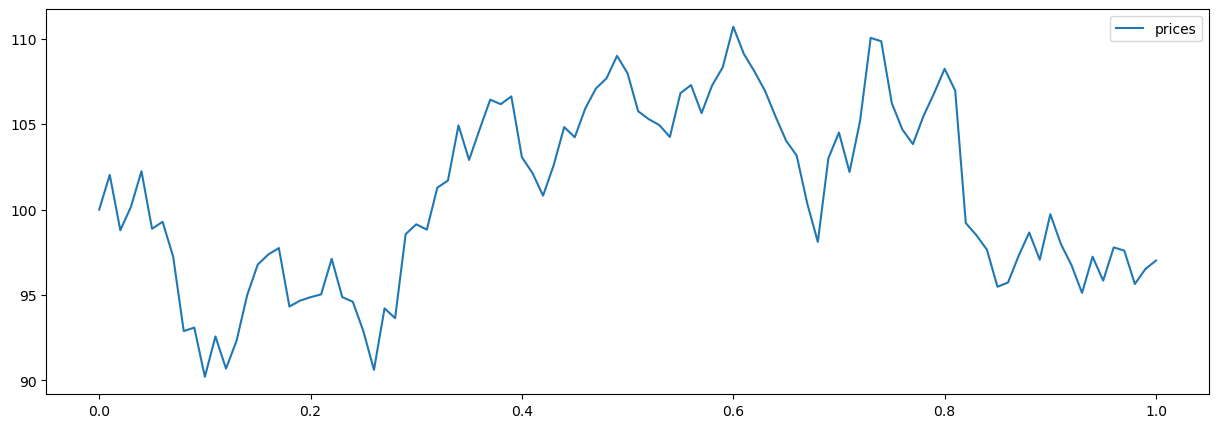

In [7]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
B = np.random.randn(N)

S = euler_maruyama_scheme(S0, r, dt, sigma, B)
df = pd.DataFrame(index=np.arange(0, T+dt, dt), data=S, columns=['prices'])
df.plot(colormap='tab10', figsize=[15,5]);

#### Milstein scheme

The Milstein scheme is obtained by using the second order stochastic Taylor expansion, after rewriting it in Itô form

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B(t) \sqrt{\Delta t} + \frac{1}{2}\sigma^{2} S_{n} ((\Delta B(t) \sqrt{\Delta t})^{2} - \Delta t)
$$

In [8]:
def milstein_scheme(S0, r, dt, sigma, B):
    """ the function returns the asset price evolution according to milstein scheme
    
    Keyword arguments:
    S0 -- the price of equity on time t0
    r -- the expected return
    dt -- the slice of time
    sigma -- the standard deviation of returns
    dB -- an array of random variables according to wiener process
    """
    return list(accumulate(B, lambda S,db: S + r*S*dt + sigma*S*db*np.sqrt(dt) + 0.5*(sigma**2)*S*((db*np.sqrt(dt))**2-dt), initial=S0))

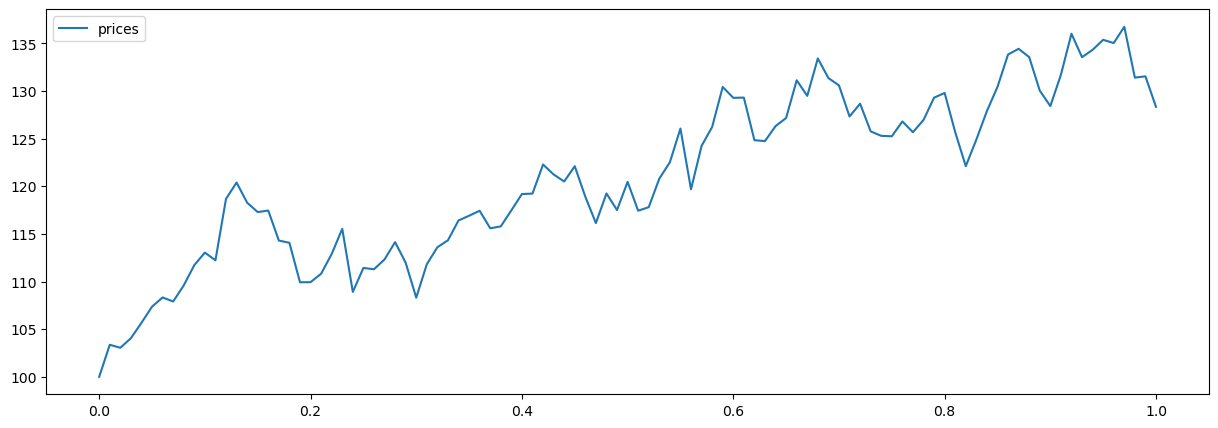

In [9]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
B = np.random.randn(N)

S = milstein_scheme(S0, r, dt, sigma, B)
df = pd.DataFrame(index=np.arange(0, T+dt, dt), data=S, columns=['prices'])
df.plot(colormap='tab10', figsize=[15,5]);

#### Closed Form

$$
S_{n+1} = S_{n}\exp{((r-\frac{\sigma^2}{2})t + \sigma B(t) \sqrt{\Delta t})}
$$m

In [10]:
def closed_form_scheme(S0, r, dt, sigma, B):
    """ the function returns the asset price evolution according to milstein scheme
    
    Keyword arguments:
    S0 -- the price of equity on time t0
    r -- the expected return
    dt -- the slice of time
    sigma -- the standard deviation of returns
    dB -- an array of random variables according to wiener process
    """
    return list(accumulate(B, lambda S,db: S * np.exp((r-0.5*sigma**2)*dt + sigma*db*np.sqrt(dt)), initial=S0))

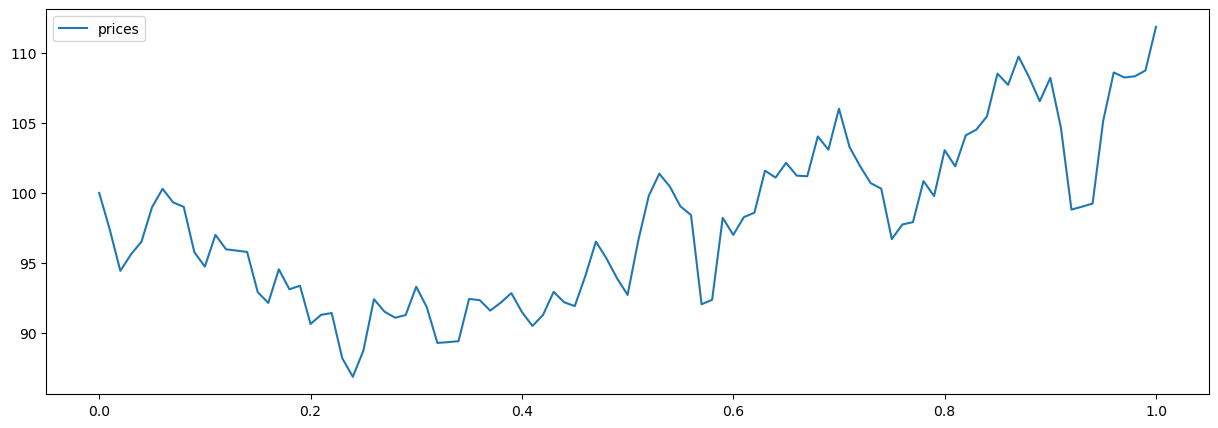

In [11]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
B = np.random.randn(N)

S = closed_form_scheme(S0, r, dt, sigma, B)
df = pd.DataFrame(index=np.arange(0, T+dt, dt), data=S, columns=['prices'])
df.plot(colormap='tab10', figsize=[15,5]);

#### Schemes Comparison

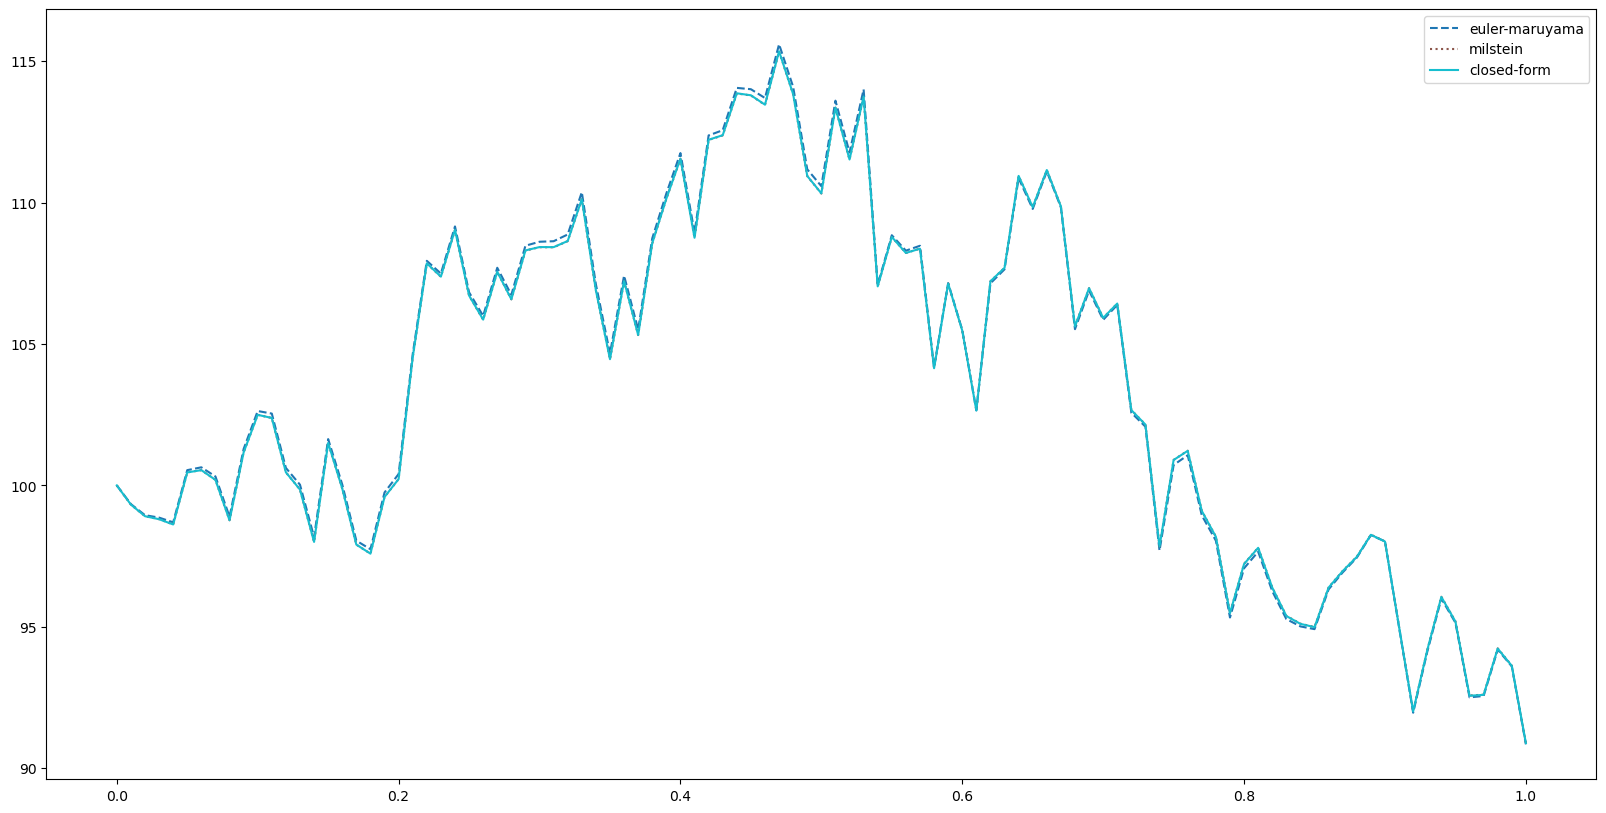

In [12]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
B = np.random.randn(N)

df_schemes = pd.DataFrame(index=np.arange(0, T+dt, dt))
df_schemes['euler-maruyama'] = euler_maruyama_scheme(S0, r, dt, sigma, B)
df_schemes['milstein'] = milstein_scheme(S0, r, dt, sigma, B)
df_schemes['closed-form'] = closed_form_scheme(S0, r, dt, sigma, B)
df_schemes.plot(style=['--', ':', '-'],colormap='tab10', figsize=[20,10]);

### Improvements in Monte Carlo method

Some techniques can be used to improve the generation of a random variable

#### Variance Reduction with Antithetic Variables

In order to get a realistic comparison we will fixed the seed value for random number generator 

In [13]:
print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31* '-')
for i in range(1, 31, 2):
    np.random.seed(100)
    sn = np.random.standard_normal(i ** 2 * 10000)
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
 0.001150944833  1.006296354600
 0.002841204001  0.995987967146
 0.001998082016  0.997701714233
 0.001322322067  0.997771186968
 0.000592711311  0.998388962646
-0.000339730751  0.998399891450
-0.000228109010  0.998657429396
 0.000295768719  0.998877333340
 0.000257107789  0.999284894532
-0.000357870642  0.999456401088
-0.000528443742  0.999617831131
-0.000300171536  0.999445228838
-0.000162924037  0.999516059328
 0.000135778889  0.999611052522
 0.000182006048  0.999619405229


The result shows that the statistics get better the larger the sample size. However it does not still match.

The *antithetic variates* technic consists in draws only half the desired number of random draws, and adds the same set of random numbers with the opposite sign afterward. The described method works for sysmmetric median 0 random variables only, like standard normally distributed random variables, which are almost exclusively used throughout. 

In [14]:
print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31* '-')
for i in range(1, 31, 2):
    np.random.seed(100)
    sn = np.random.standard_normal(i ** 2 * int(10000 / 2))
    sn = np.concatenate((sn, -sn))
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
-0.000000000000  1.017474904235
 0.000000000000  0.998944776883
 0.000000000000  0.998018870658
 0.000000000000  0.997916558845
-0.000000000000  0.998119811838
 0.000000000000  0.998365584578
 0.000000000000  0.998171301115
-0.000000000000  0.998359568664
-0.000000000000  0.998772594780
-0.000000000000  0.998640403762
 0.000000000000  0.998868127277
 0.000000000000  0.999102053335
 0.000000000000  0.999342143561
 0.000000000000  0.999449673443
-0.000000000000  0.999613960655


This results in a mean value of zero, even in smaller sample sizes.

#### Quasi-MonteCarlo using Sobol low-discrepancy sequence

Quasi-Monte Carlo simulation is the traditional Monte Carlo simulation but using **quasi-random sequences** instead (pseudo) random numbers. These sequences are known as **low-discrepancy sequences** and they are **totally deterministic**, used in several cases to improve the performance of Monte Carlo simulations, offering shorter computational times and/or higher accuracy.

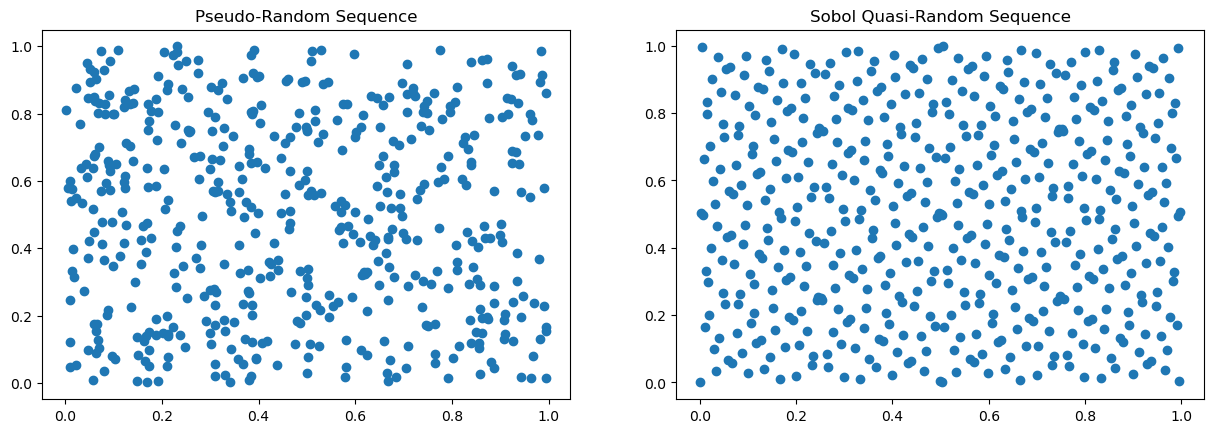

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
ax1.set_title('Pseudo-Random Sequence')
ax1.scatter(x=np.random.rand(2**9), y=np.random.rand(2**9))
sampler = qmc.Sobol(d=2, scramble=False)
sample_sequence = sampler.random_base2(m=9)
ax2.set_title('Sobol Quasi-Random Sequence')
ax2.scatter(x=sample_sequence[:,0], y=sample_sequence[:,1]);

From the figure above we can see that quasi random sequence the points distribution is more homegenous than pseudo random. It is also possible to observe some small empty clusters in the pseudo-random sequence. 

#### Brownian Bridge

A Brownian bridge is acontinuous-time stochastic process $B(t)$ whose probability distribution is the conditional provability distribution of a Wiener process $W(t)$ subject to the condition (when standardized) that $W(T) = 0$. More precisely:

$$
B_t := (W_t|W_T = 0), t \in [0,T]
$$

Generally, a Brownian bridge can be defined as:

Suppose: $\{ W_t \}_{t \in [0,T]}$ is an 1-dimenstional Brownian motion, $a,b \in \mathbb{R}$, then the process

$$
B_t^{a,b} = a \frac{T-t}{T} + b \frac{t}{T} + \left( W_t - \frac{t}{T}W_T \right), t \in [0,T]
$$

is a Browninan bridge from $a$ to $b$

Is satisfies

$$
B_t^{a,b} \sim \mathcal{N}\left( a + \frac{t}{T}(b-a), t-\frac{t^2}{T} \right)
$$

where $\mathcal{N}$ is normal provability distribution 

The algorithm idea is to generate a random jump from a point $x_0$ at time 0 toa apiont $x_T$ at time $T$ and this can be expressed as

$$
x_T = x_0 + \sqrt{T}Z_t
$$

where $Z$ is a standard Brownian motion.

Now, given the point $x_0$ and the final point $x_T$, the Brownian bridge algorithm provides the formula for an intermediate point $x_t$

$$
x_t = (1-\gamma_t)x_0 + \gamma_t x_T + \sqrt{\gamma_t (1-\gamma_t)T}Z_t
$$

where $\gamma_t = \frac{t}{T}$

Once $x_t$ has been determined, formula above can be used for the subintervals $(0,t)$ and $(t,T)$. The recursive implementation of the algorithm procues a random path connecting $x_0$ and $x_T$



This first algorithm implements brownian bridge with length $N=2^K$ 

Define the Black Scholes Merton close formula to solve an European Call

Defining the parameters

The exact solution

### Portfolio P&L Study

Let´s define the Black Scholes Merton function to calculate a call value and their greeks.

In [46]:
def get_asset_path(S0, r, dt, sigma, B):
    return list(accumulate(B, lambda S,db: S * np.exp((r-0.5*sigma**2)*dt + sigma*db*np.sqrt(dt)), initial=S0))

def get_d(S, sigma, div, r, K, dt):
    d1 = (np.log(S / K) + (r - div + 0.5 * sigma**2) * dt) / sigma / np.sqrt(dt)
    d2 = d1 - sigma * np.sqrt(dt)
    return d1, d2

def get_N(S, sigma, div, r, K, dt):
    d1, d2 = get_d(S, sigma, div, r, K, dt)
    return norm.cdf(d1), norm.cdf(d2)

def get_deltaN(d):
    return (1.0 / np.sqrt(2*np.pi))*np.exp(-d**2/2)

def get_call(S, sigma, div, r, K, dt):
    if dt == 0:
        return max(S-K, 0)

    N1, N2 = get_N(S, sigma, div, r, K, dt)
    return S * np.exp(-div * dt) * N1 - K * np.exp(-r * dt) * N2

def get_delta(S, sigma, div, r, K, dt):
    if dt == 0:
        return 1 if max(S-K, 0) > 0 else 0
    N1, N2 = get_N(S, sigma, div, r, K, dt)
    return np.exp(-div * dt) * N1

def get_gamma(S, sigma, div, r, K, dt):
    if dt == 0:
        return 0
    d1, d2 = get_d(S, sigma, div, r, K, dt)
    return np.exp(-div * dt) * get_deltaN(d1) / sigma / S / np.sqrt(dt)

def get_vega(S, sigma, div, r, K, dt):
    if dt == 0:
        return 0
    d1, d2 = get_d(S, sigma, div, r, K, dt)
    return S * np.sqrt(dt) * np.exp(-div * dt) * get_deltaN(d1)

Let´s also create the function responsible to calculate the portfolio P&L

In [63]:
def get_portfolio(S0, r, K, T, N, B, vol_local, vol_impl, repl_vol='implied'):
    dt = T/N
    df = pd.DataFrame(index=np.arange(0, T+dt, dt), data=np.arange(0, T+dt, dt), columns=['t'])
    df['S'] = get_asset_path(S0, r, dt, vol_local, B)
    df['S_return'] = df.S.pct_change()
    df['option'] = df.apply(lambda row: get_call(row.S, vol_impl, 0, r, K, T-row.t), axis=1)
    df['vol_local'] = vol_local
    df['vol_impl'] = vol_impl

    for vol_type in ['local', 'impl']:
        df['delta_' + vol_type] = df.apply(lambda row: get_delta(row.S, row['vol_' + vol_type], 0, r, K, T-row.t), axis=1)
        df['portfolio_' + vol_type] = df.option - df['delta_' + vol_type]*df.S
        df['cashflow_delta_' + vol_type] = (df['delta_' + vol_type] - df['delta_' + vol_type].shift(1)) * df.S
        df['cash_account_' + vol_type] = list(accumulate(df['cashflow_delta_' + vol_type].values[1:], lambda a,b: a * np.exp(r*dt) + b, initial=-df['portfolio_' + vol_type].values[0]))
        df['pl_cum_' + vol_type] = df['portfolio_' + vol_type] + df['cash_account_' + vol_type]
        
        df['gamma_' + vol_type] = df.apply(lambda row: get_gamma(row.S, row['vol_' + vol_type], 0, r, K, T-row.t), axis=1)
        df['pl_realized_implied_' + vol_type] = df.apply(lambda row: 0.5*row['gamma_' + vol_type]*row.S**2*(row.S_return**2-row['vol_' + vol_type]**2*dt), axis=1)
        df['made_money_' + vol_type] = df.apply(lambda row: row.S_return**2 >= row['vol_' + vol_type]**2*dt, axis=1)
        df['gamma_total_pl_' + vol_type] = df.apply(lambda row: row['pl_realized_implied_' + vol_type]*np.exp(-r*dt), axis=1)

        df['actual_pl_' + vol_type] = df.loc[T]['pl_cum_' + vol_type]*np.exp(-r*T)

    return df

def plot_portfolio(vol_type = 'local'):
    fig, ax = plt.subplots(3, 1, figsize=(15,10)) 
    portfolio.plot(x = 't', y = 'S', ax = ax[0]) 
    portfolio.plot(x = 't', y = 'pl_cum_' + vol_type, ax = ax[0], secondary_y = True) 
    portfolio.plot(x = 't', y = 'S', ax = ax[1]) 
    portfolio.plot(x = 't', y = 'gamma_' + vol_type, ax = ax[1], secondary_y = True) 
    portfolio.plot(x = 't', y = 'pl_realized_implied_' + vol_type, ax = ax[2]) 
    portfolio.plot(x = 't', y = 'gamma_' + vol_type, ax = ax[2], secondary_y = True);

Now, we will simulate the porfolio P&L under arbitrage condition where we know that the future realized volatility is greater than implied volatility, thus:

$$
V_{local} > V_{implied}
$$

In [70]:
S0 = 100
r = 0.02
K = 100
T = 1
N = 200
vol_local = 0.35
vol_impl = 0.2
B = pd.read_csv('bs.csv').B.values #np.random.randn(N)

portfolio = get_portfolio(S0, r, K, T, N, B, vol_local, vol_impl)
portfolio.head()

,t,S,S_return,option,vol_local,vol_impl,delta_local,portfolio_local,cashflow_delta_local,cash_account_local,...,delta_impl,portfolio_impl,cashflow_delta_impl,cash_account_impl,pl_cum_impl,gamma_impl,pl_realized_implied_impl,made_money_impl,gamma_total_pl_impl,actual_pl_impl
0.000,0.000,100.000000,NaN,8.916037,0.35,0.2,0.591786,-50.262610,NaN,50.262610,...,0.579260,-49.009934,NaN,49.009934,0.000000,0.019552,NaN,False,NaN,4.725325
0.005,0.005,106.059131,0.060591,12.743657,0.35,0.2,0.655444,-56.772127,6.751426,57.019062,...,0.689478,-60.381748,11.689624,60.704459,0.322711,0.016686,0.325768,True,0.325735,4.725325
0.010,0.010,108.861339,0.026421,14.714747,0.35,0.2,0.682530,-59.586424,2.948697,59.973461,...,0.734231,-65.214625,4.871906,65.582436,0.367811,0.015142,0.044689,True,0.044685,4.725325
0.015,0.015,106.719151,-0.019678,13.152754,0.35,0.2,0.661882,-57.482767,-2.203542,57.775917,...,0.700595,-61.614164,-3.589593,61.999401,0.385238,0.016399,0.017484,True,0.017482,4.725325
0.020,0.020,107.102191,0.003589,13.397492,0.35,0.2,0.665615,-57.891376,0.399819,58.181515,...,0.706965,-62.319979,0.682198,62.687800,0.367820,0.016221,-0.017408,False,-0.017407,4.725325


Portfolio P&L study delta hedging with local volatility

In [71]:
portfolio[['S', 'option']+[col for col in portfolio.columns if col.endswith('_local')]]

,S,option,vol_local,delta_local,portfolio_local,cashflow_delta_local,cash_account_local,pl_cum_local,gamma_local,pl_realized_implied_local,made_money_local,gamma_total_pl_local,actual_pl_local
0.000,100.000000,8.916037,0.35,0.591786,-50.262610,NaN,50.262610,0.000000,1.109532e-02,NaN,False,NaN,5.985449
0.005,106.059131,12.743657,0.35,0.655444,-56.772127,6.751426,57.019062,0.246935,9.945543e-03,1.710987e-01,True,1.710816e-01,5.985449
0.010,108.861339,14.714747,0.35,0.682530,-59.586424,2.948697,59.973461,0.387037,9.401582e-03,4.767469e-03,True,4.766992e-03,5.985449
0.015,106.719151,13.152754,0.35,0.661882,-57.482767,-2.203542,57.775917,0.293150,9.863073e-03,-1.265237e-02,False,-1.265110e-02,5.985449
0.020,107.102191,13.397492,0.35,0.665615,-57.891376,0.399819,58.181515,0.290139,9.810313e-03,-3.373835e-02,False,-3.373497e-02,5.985449
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.980,159.692296,59.732288,0.35,1.000000,-99.960008,0.000000,106.063929,6.103921,1.409362e-21,-7.113298e-21,False,-7.112586e-21,5.985449
0.985,162.475552,62.505547,0.35,1.000000,-99.970004,0.000000,106.074536,6.104531,6.015127e-30,-2.451186e-29,False,-2.450941e-29,5.985449
0.990,162.783379,62.803377,0.35,1.000000,-99.980002,0.000000,106.085144,6.105142,4.171161e-44,-3.365120e-43,False,-3.364783e-43,5.985449
0.995,159.682702,59.692701,0.35,1.000000,-99.990000,0.000000,106.095753,6.105752,1.634353e-79,-5.202511e-79,False,-5.201991e-79,5.985449


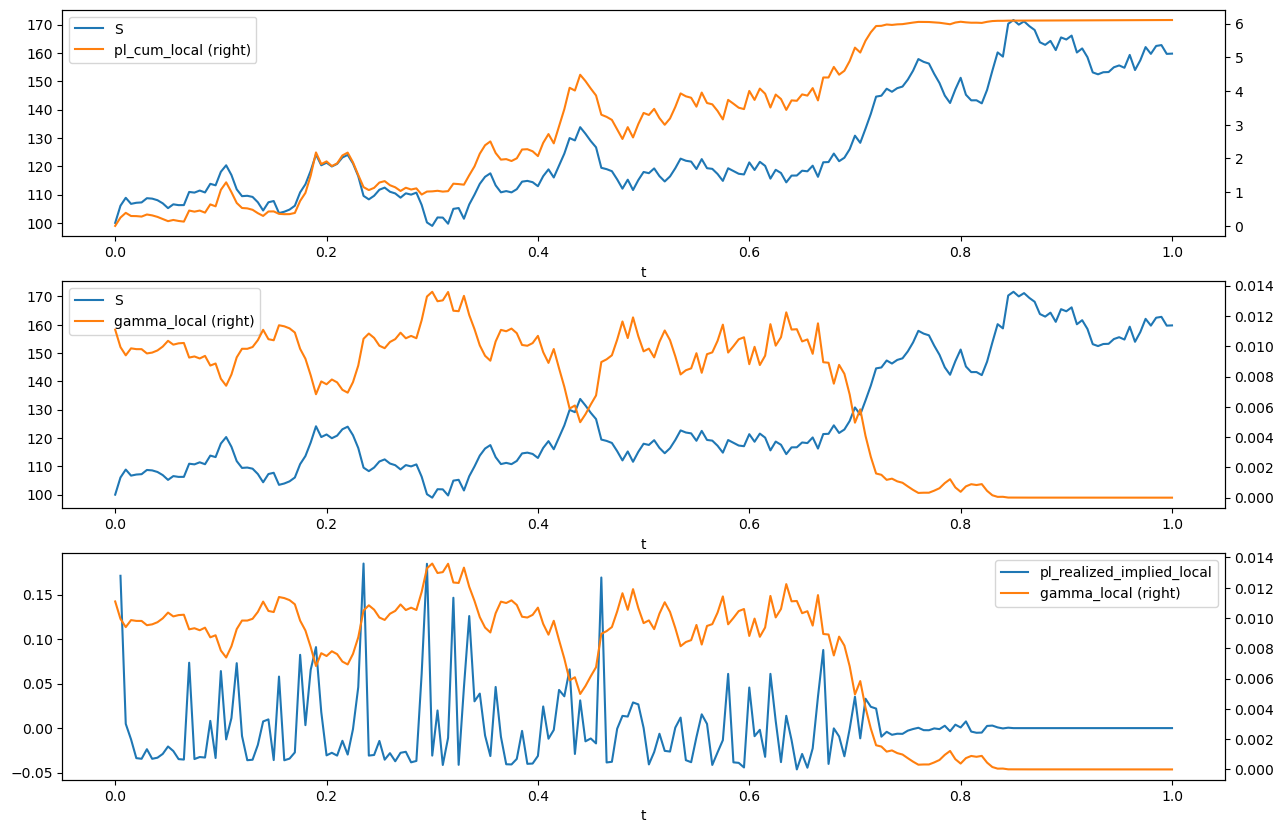

In [72]:
plot_portfolio('local')

Portfolio P&L study delta hedging with implied volatility

In [73]:
portfolio[['S', 'option']+[col for col in portfolio.columns if col.endswith('_impl')]]

,S,option,vol_impl,delta_impl,portfolio_impl,cashflow_delta_impl,cash_account_impl,pl_cum_impl,gamma_impl,pl_realized_implied_impl,made_money_impl,gamma_total_pl_impl,actual_pl_impl
0.000,100.000000,8.916037,0.2,0.579260,-49.009934,NaN,49.009934,0.000000,1.955213e-02,NaN,False,NaN,4.725325
0.005,106.059131,12.743657,0.2,0.689478,-60.381748,11.689624,60.704459,0.322711,1.668588e-02,3.257679e-01,True,3.257353e-01,4.725325
0.010,108.861339,14.714747,0.2,0.734231,-65.214625,4.871906,65.582436,0.367811,1.514211e-02,4.468918e-02,True,4.468471e-02,4.725325
0.015,106.719151,13.152754,0.2,0.700595,-61.614164,-3.589593,61.999401,0.385238,1.639889e-02,1.748408e-02,True,1.748233e-02,4.725325
0.020,107.102191,13.397492,0.2,0.706965,-62.319979,0.682198,62.687800,0.367820,1.622107e-02,-1.740846e-02,False,-1.740672e-02,4.725325
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.980,159.692296,59.732288,0.2,1.000000,-99.960008,0.000000,104.778863,4.818855,1.870997e-61,3.976538e-62,True,3.976140e-62,4.725325
0.985,162.475552,62.505547,0.2,1.000000,-99.970004,0.000000,104.789342,4.819337,3.418734e-87,4.682344e-87,True,4.681876e-87,4.725325
0.990,162.783379,62.803377,0.2,1.000000,-99.980002,0.000000,104.799821,4.819819,9.835091e-131,-2.559370e-130,False,-2.559115e-130,4.725325
0.995,159.682702,59.692701,0.2,1.000000,-99.990000,0.000000,104.810302,4.820301,1.669940e-239,3.466554e-239,True,3.466207e-239,4.725325


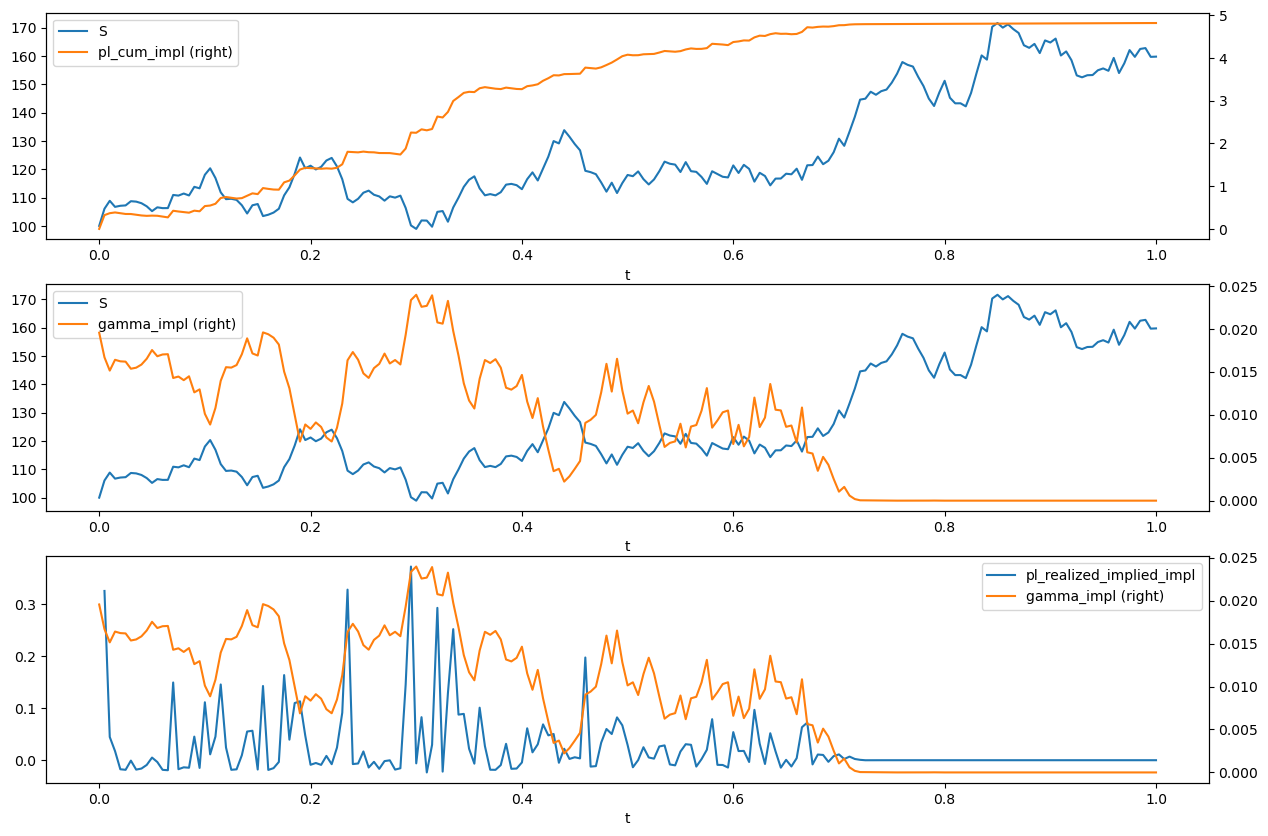

In [74]:
plot_portfolio('impl')

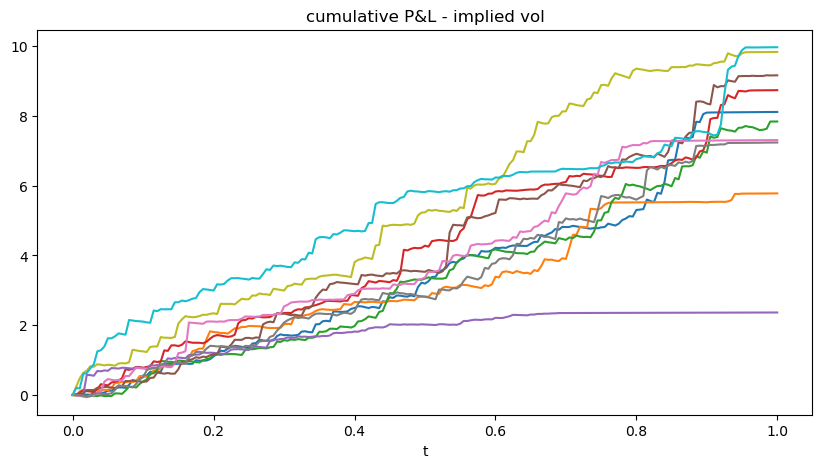

In [89]:
S0 = 100
r = 0.02
K = 100
T = 1
N = 200
vol_local = 0.35
vol_impl = 0.20

fig, ax = plt.subplots(figsize=(10,5))
for i in range(10):
    B = np.random.randn(N)
    portfolio = get_portfolio(S0, r, K, T, N, B, vol_local, vol_impl)
    portfolio.plot(x = 't', y = 'pl_cum_impl', ax = ax, legend=False)
    ax.set_title('cumulative P&L - implied vol')

In [151]:
df['gamma_total_pl'].sum()

4.6935579775520075

In [836]:
S0 = 100
r = 0.02
K = 100
T = 1
N = 200
sigma_impl = 0.2
sigma_local = 0.35

def get_portfolio_pl(S0, r, B, T, N, sigma_local, sigma_impl, sigma_repl):
    
    dt = T/N
    df = pd.DataFrame(index=np.arange(0, T+dt, dt), data=np.arange(0, T+dt, dt), columns=['time'])
    df['asset_price'] = get_asset_path(S0, r, dt, sigma_local, B)
    df['option_value'] = df.apply(lambda row: get_call(row.asset_price, sigma_impl, 0, r, K, T-row.time), axis=1)
    df['delta_repl_vol'] = df.apply(lambda row: get_delta(row.asset_price, sigma_repl, 0, r, K, T-row.time), axis=1)
    df['portfolio'] = df.option_value - df.delta_repl_vol*df.asset_price
    df['cashflow_delta'] = (df.delta_repl_vol - df.delta_repl_vol.shift(1)) * df.asset_price
    df['cash_account'] = list(accumulate(df.cashflow_delta.values[1:], lambda a,b: a * np.exp(r*dt) + b, initial=-df.portfolio.values[0]))
    df['pl_cumulative'] = df.portfolio + df.cash_account
    return df, np.exp(-r*T)*df.loc[T].pl_cumulative

df, pl = get_portfolio_pl(S0, r, B, T, N, sigma_local, sigma_impl, sigma_local)

pl_theo = get_call(S0, sigma_local, 0, r, K, T) - get_call(S0, sigma_impl, 0, r, K, T)
pl_theo


def calculate_pl():
    B = np.random.randn(N)
    df, portfolio_pl = get_portfolio_pl(S0, r, B, T, N, sigma_local, sigma_impl, sigma_local)
    return portfolio_pl

portfolio_pls = [calculate_pl() for i in range(500)] 

np.mean(portfolio_pls), pl_theo

(5.823955548201095, 5.850746360853513)

### Minimum Variance Delta

### Local Volatility

In [139]:
S = 15.7
r = 0.01

In [290]:
df_vol_impl = pd.read_excel(r'papers\LocalVol.xlsx', sheet_name='data')
df_vol_impl

,strike,0.08,0.17,0.25,0.33,0.42,0.5,1,2,3
0,15.70,0.322,0.293,0.291,0.295,0.297,0.298,0.299,0.306,0.3062
1,16.49,0.320,0.291,0.289,0.293,0.294,0.294,0.296,0.306,0.3063
2,17.27,0.336,0.293,0.290,0.293,0.293,0.293,0.293,0.306,0.3059
3,18.06,0.350,0.297,0.294,0.295,0.294,0.293,0.293,0.305,0.3046
4,18.84,0.350,0.307,0.302,0.299,0.297,0.295,0.292,0.303,0.3034
5,19.63,0.350,0.310,0.305,0.302,0.299,0.297,0.291,0.302,0.3022
6,20.41,0.350,0.310,0.307,0.306,0.304,0.300,0.291,0.299,0.2989
7,21.20,0.350,0.310,0.309,0.312,0.310,0.304,0.291,0.294,0.2938
8,21.98,0.350,0.310,0.310,0.314,0.313,0.307,0.292,0.289,0.2888
9,22.77,0.350,0.310,0.310,0.314,0.314,0.308,0.294,0.289,0.2890


In [296]:
np_vol_impl = df_vol_impl.to_numpy()
vol_impl = np.array(np_vol_impl[:,1:], dtype=np.float64)
strike = np.array(np_vol_impl[:,0], dtype=np.float64)
expiry = np.array(df_vol_impl.columns.values[1:], dtype=np.float64)

In [297]:
vol_impl, strike, expiry

(array([[0.322 , 0.293 , 0.291 , 0.295 , 0.297 , 0.298 , 0.299 , 0.306 ,
         0.3062],
        [0.32  , 0.291 , 0.289 , 0.293 , 0.294 , 0.294 , 0.296 , 0.306 ,
         0.3063],
        [0.336 , 0.293 , 0.29  , 0.293 , 0.293 , 0.293 , 0.293 , 0.306 ,
         0.3059],
        [0.35  , 0.297 , 0.294 , 0.295 , 0.294 , 0.293 , 0.293 , 0.305 ,
         0.3046],
        [0.35  , 0.307 , 0.302 , 0.299 , 0.297 , 0.295 , 0.292 , 0.303 ,
         0.3034],
        [0.35  , 0.31  , 0.305 , 0.302 , 0.299 , 0.297 , 0.291 , 0.302 ,
         0.3022],
        [0.35  , 0.31  , 0.307 , 0.306 , 0.304 , 0.3   , 0.291 , 0.299 ,
         0.2989],
        [0.35  , 0.31  , 0.309 , 0.312 , 0.31  , 0.304 , 0.291 , 0.294 ,
         0.2938],
        [0.35  , 0.31  , 0.31  , 0.314 , 0.313 , 0.307 , 0.292 , 0.289 ,
         0.2888],
        [0.35  , 0.31  , 0.31  , 0.314 , 0.314 , 0.308 , 0.294 , 0.289 ,
         0.289 ],
        [0.35  , 0.31  , 0.31  , 0.314 , 0.315 , 0.311 , 0.296 , 0.289 ,
         0.2894],

In [308]:
def get_local_volatility_surface(S, r, vol_impl, strike, expiry):

    a = np.log(S/strike)
    b = (r+vol_impl**2/2)*expiry
    c = vol_impl*np.sqrt(expiry)
    d = (a + b.T).T / c

    d_expiry = np.diff(expiry)
    d_vol_expiry = np.diff(vol_impl)
    d_vol_d_expiry = d_vol_expiry / d_expiry

    d_strike = np.diff(strike)
    d_vol_strike = np.diff(vol_impl, axis=0)
    d_vol_d_strike = (d_vol_strike.T / d_strike).T

    d_2_strike = (strike[2:] - strike[:-2])**2
    d_2_vol_strike = np.diff(d_vol_strike, axis=0)
    d_2_vol_d_2_strike = (d_2_vol_strike.T / d_2_strike).T

    numerator = vol_impl[2:,1:]**2 + 2*vol_impl[2:,1:]*expiry[1:]*(d_vol_d_expiry[2:] + (r*strike[2:]*d_vol_d_strike[1:,1:].T).T)

    f = (1+((strike[2:]*d[2:,1:].T).T * d_vol_d_strike[1:,1:]) * np.sqrt(expiry[1:]))**2
    g = (vol_impl[2:,1:].T * strike[2:]**2).T * expiry[1:]
    h = d_2_vol_d_2_strike[:,1:] - d[2:,1:]*d_vol_d_strike[1:,1:]**2*np.sqrt(expiry[1:])

    denominator = f+g*h

    return  np.sqrt(numerator/denominator), strike[2:], expiry[1:]

vol_local, strike_local, expiry_local = get_local_volatility_surface(S, r, vol_impl, strike, expiry)

vol_local, strike_local, expiry_local, vol_local.shape, strike_local.shape, expiry_local.shape

(array([[0.19587057, 0.2786097 , 0.30161581, 0.28709872, 0.28399353,
         0.28952619, 0.33098036, 0.31490758],
        [0.17565044, 0.29177151, 0.30101559, 0.28731969, 0.28394292,
         0.27731592, 0.34102593, 0.32147874],
        [0.23714043, 0.31233798, 0.29799317, 0.29377744, 0.28356077,
         0.28864995, 0.33428038, 0.30134906],
        [0.24198875, 0.31529815, 0.30766302, 0.29780318, 0.29411066,
         0.27445914, 0.30594824, 0.30021188],
        [0.22496164, 0.31294554, 0.32620219, 0.31609249, 0.28801994,
         0.26594498, 0.33344273, 0.34371739],
        [0.22193593, 0.32194745, 0.36974025, 0.34537944, 0.28748499,
         0.26372144, 0.30071909, 0.31275748],
        [0.22193593, 0.32201368, 0.36728538, 0.35350908, 0.29732356,
         0.26014778, 0.25054935, 0.25784563],
        [0.22193593, 0.31255806, 0.33752645, 0.3344793 , 0.2870245 ,
         0.27322128, 0.21988569, 0.20762951],
        [0.22193593, 0.31      , 0.33008787, 0.33183222, 0.30697897,
         0.

In [312]:
np.meshgrid(expiry_local, strike_local)

[array([[0.17, 0.25, 0.33, 0.42, 0.5 , 1.  , 2.  , 3.  ],
        [0.17, 0.25, 0.33, 0.42, 0.5 , 1.  , 2.  , 3.  ],
        [0.17, 0.25, 0.33, 0.42, 0.5 , 1.  , 2.  , 3.  ],
        [0.17, 0.25, 0.33, 0.42, 0.5 , 1.  , 2.  , 3.  ],
        [0.17, 0.25, 0.33, 0.42, 0.5 , 1.  , 2.  , 3.  ],
        [0.17, 0.25, 0.33, 0.42, 0.5 , 1.  , 2.  , 3.  ],
        [0.17, 0.25, 0.33, 0.42, 0.5 , 1.  , 2.  , 3.  ],
        [0.17, 0.25, 0.33, 0.42, 0.5 , 1.  , 2.  , 3.  ],
        [0.17, 0.25, 0.33, 0.42, 0.5 , 1.  , 2.  , 3.  ],
        [0.17, 0.25, 0.33, 0.42, 0.5 , 1.  , 2.  , 3.  ],
        [0.17, 0.25, 0.33, 0.42, 0.5 , 1.  , 2.  , 3.  ]]),
 array([[17.27, 17.27, 17.27, 17.27, 17.27, 17.27, 17.27, 17.27],
        [18.06, 18.06, 18.06, 18.06, 18.06, 18.06, 18.06, 18.06],
        [18.84, 18.84, 18.84, 18.84, 18.84, 18.84, 18.84, 18.84],
        [19.63, 19.63, 19.63, 19.63, 19.63, 19.63, 19.63, 19.63],
        [20.41, 20.41, 20.41, 20.41, 20.41, 20.41, 20.41, 20.41],
        [21.2 , 21.2 , 21.2 , 

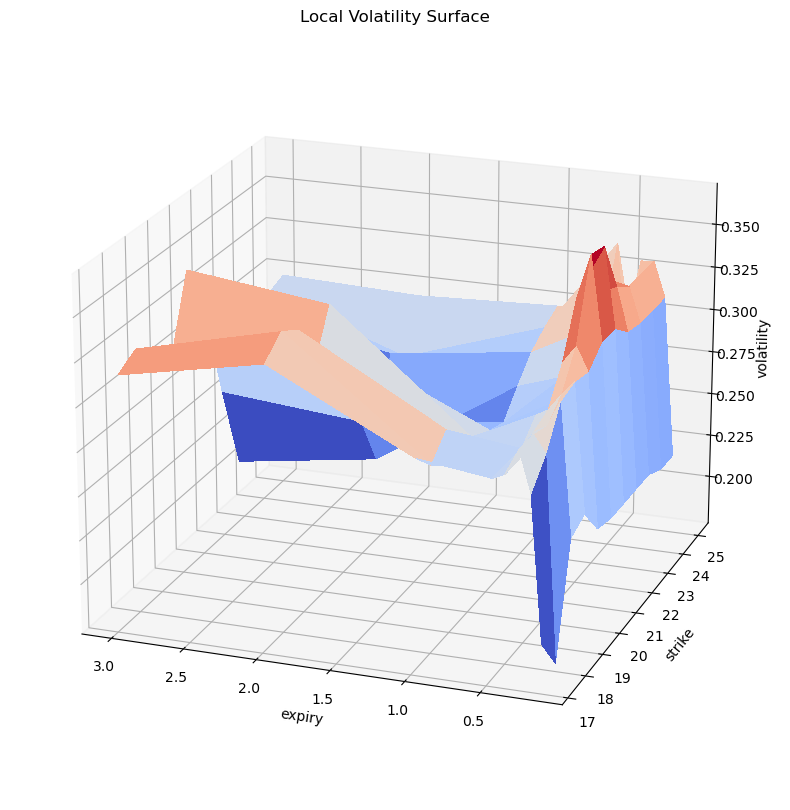

In [378]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,10))

X, Y = np.meshgrid(expiry_local, strike_local)

# Plot the surface.
surf = ax.plot_surface(X, Y, vol_local, cmap=cm.coolwarm, linewidth=0, antialiased=False)

#ax.view_init(-160, -30)
ax.view_init(-160, 70)
ax.invert_zaxis()

plt.title('Local Volatility Surface')
ax.set_xlabel('expiry')
ax.set_ylabel('strike')
ax.set_zlabel('volatility')
plt.show()

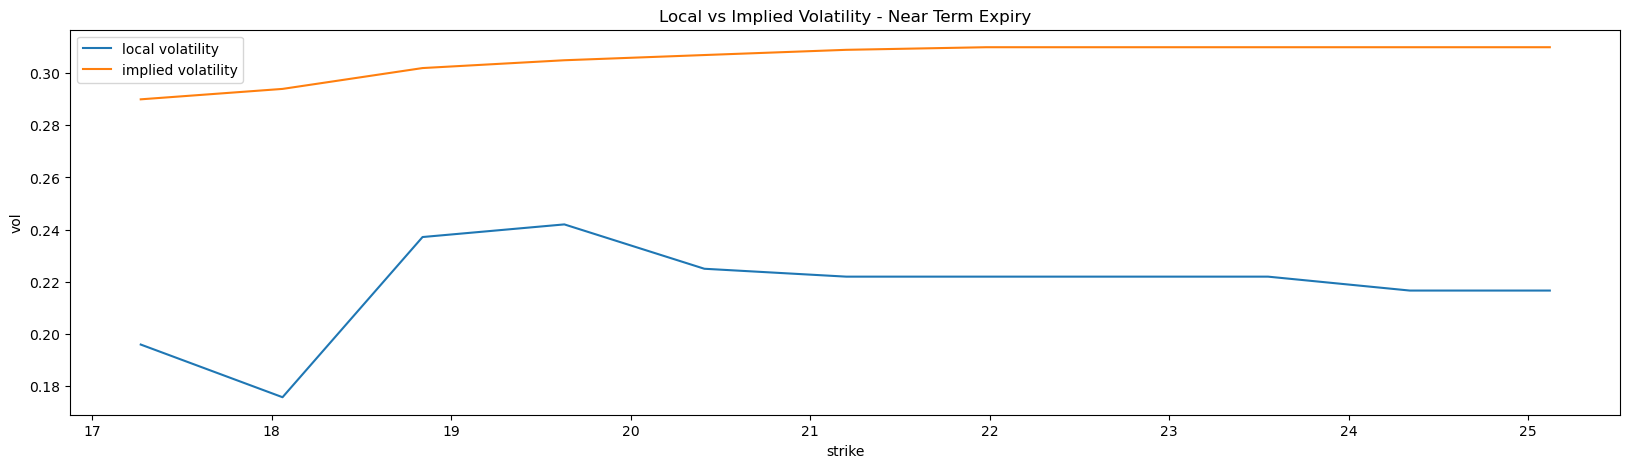

In [394]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(strike_local, vol_local[:,0])
ax.plot(strike[2:], vol_impl[2:,2])

plt.title('Local vs Implied Volatility - Near Term Expiry')
ax.set_xlabel('strike')
ax.set_ylabel('vol')
ax.legend(['local volatility', 'implied volatility'])

#### Load option data

In [51]:
df_opt = pd.read_csv('data.csv', parse_dates=['ref_date', 'expiry'])
df_opt.head()

,ref_date,option_price,sigma_impl,asset_price,option_ticker,ticker,K,expiry,r,t
0,2023-05-01,11.62,23.619,304.8936,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.302778
1,2023-05-02,11.87,24.451,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.300000
2,2023-05-03,11.37,24.593,303.7361,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.297222
3,2023-05-04,12.74,25.510,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.294444
4,2023-05-05,14.10,24.573,309.9725,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.291667


In [52]:
df_opt['call_option'] = df_opt.apply(lambda row: get_call(row.asset_price, row.sigma_impl/100.0, 0, row.r, row.K, row.t), axis=1)
df_opt['D_call_option'] = df_opt.call_option - df_opt.call_option.shift(1)
df_opt['D_sigma_impl'] = df_opt.sigma_impl - df_opt.sigma_impl.shift(1)
df_opt['sqrt_t'] = np.sqrt(df_opt.t)
df_opt['D_S'] = df_opt.asset_price - df_opt.asset_price.shift(1)
df_opt['delta_bs'] = df_opt.apply(lambda row: get_delta(row.asset_price, row.sigma_impl/100.0, 0, row.r, row.K, row.t), axis=1)
df_opt['vega_bs'] = df_opt.apply(lambda row: get_vega(row.asset_price, row.sigma_impl/100.0, 0, row.r, row.K, row.t), axis=1)
df_opt['y_serie'] = df_opt.apply(lambda row: (row.sqrt_t * row.asset_price*(row.D_call_option - row.delta_bs*row.D_S))/(row.vega_bs*row.D_S), axis=1)
df_opt

,ref_date,option_price,sigma_impl,asset_price,option_ticker,ticker,K,expiry,r,t,call_option,D_call_option,D_sigma_impl,sqrt_t,D_S,delta_bs,vega_bs,y_serie
0,2023-05-01,11.62,23.619,304.8936,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.302778,10.397202,NaN,NaN,0.550252,NaN,0.397234,64.696879,NaN
1,2023-05-02,11.87,24.451,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.300000,10.797242,0.400040,0.832,0.547723,-0.1497,0.400138,64.492220,-7.951844
2,2023-05-03,11.37,24.593,303.7361,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.297222,10.410576,-0.386666,0.142,0.545181,-1.0078,0.390633,63.563065,-0.018129
3,2023-05-04,12.74,25.510,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.294444,11.315561,0.904985,0.917,0.542627,1.0078,0.404723,64.079617,1.272890
4,2023-05-05,14.10,24.573,309.9725,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.291667,12.849303,1.533743,-0.937,0.540062,5.2286,0.448444,66.226193,-0.392074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2023-08-09,6.54,25.227,322.2300,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.025000,6.391898,-2.400014,1.554,0.158114,-3.8200,0.581832,19.896601,0.118927
70,2023-08-10,6.35,24.182,322.9300,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.022222,6.319414,-0.072484,-1.045,0.149071,0.7000,0.611487,18.450025,-1.865662
71,2023-08-11,4.28,22.325,321.0100,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.019444,4.572447,-1.746967,-1.857,0.139443,-1.9200,0.551434,17.709116,0.906028
72,2023-08-14,5.50,20.097,324.0400,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.011111,5.256464,0.684017,-2.228,0.105409,3.0300,0.730167,11.290306,-1.526028


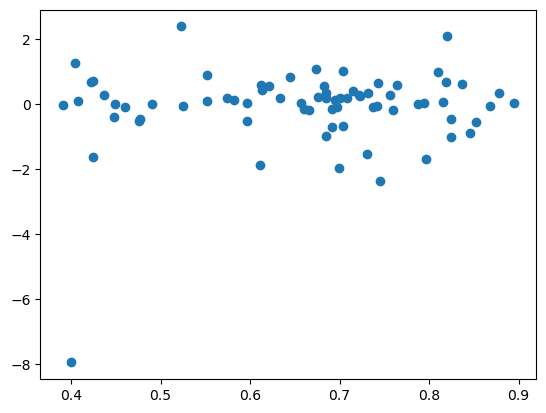

In [117]:
df_fit = df_opt[['delta_bs', 'y_serie']].dropna()
x = df_fit.delta_bs.values
y = df_fit.y_serie.values

plt.scatter(x, y)

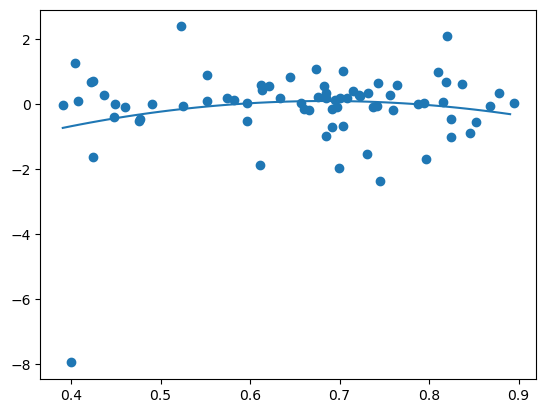

In [118]:
model = np.poly1d(np.polyfit(x, y, 2))
#add fitted polynomial line to scatterplot
polyline = np.arange(min(x), max(x), 0.01)
plt.scatter(x, y)
plt.plot(polyline, model(polyline))
plt.show()

In [119]:
print(model)

       2
-9.57 x + 13.11 x - 4.39


In [120]:
coefs = np.poly1d(model)
df_opt['a'] = coefs[0]
df_opt['b'] = coefs[1]
df_opt['c'] = coefs[2]
df_opt

,ref_date,option_price,sigma_impl,asset_price,option_ticker,ticker,K,expiry,r,t,...,D_call_option,D_sigma_impl,sqrt_t,D_S,delta_bs,vega_bs,y_serie,a,b,c
0,2023-05-01,11.62,23.619,304.8936,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.302778,...,NaN,NaN,0.550252,NaN,0.397234,64.696879,NaN,-4.390411,13.107971,-9.570302
1,2023-05-02,11.87,24.451,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.300000,...,0.400040,0.832,0.547723,-0.1497,0.400138,64.492220,-7.951844,-4.390411,13.107971,-9.570302
2,2023-05-03,11.37,24.593,303.7361,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.297222,...,-0.386666,0.142,0.545181,-1.0078,0.390633,63.563065,-0.018129,-4.390411,13.107971,-9.570302
3,2023-05-04,12.74,25.510,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.294444,...,0.904985,0.917,0.542627,1.0078,0.404723,64.079617,1.272890,-4.390411,13.107971,-9.570302
4,2023-05-05,14.10,24.573,309.9725,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.291667,...,1.533743,-0.937,0.540062,5.2286,0.448444,66.226193,-0.392074,-4.390411,13.107971,-9.570302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2023-08-09,6.54,25.227,322.2300,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.025000,...,-2.400014,1.554,0.158114,-3.8200,0.581832,19.896601,0.118927,-4.390411,13.107971,-9.570302
70,2023-08-10,6.35,24.182,322.9300,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.022222,...,-0.072484,-1.045,0.149071,0.7000,0.611487,18.450025,-1.865662,-4.390411,13.107971,-9.570302
71,2023-08-11,4.28,22.325,321.0100,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.019444,...,-1.746967,-1.857,0.139443,-1.9200,0.551434,17.709116,0.906028,-4.390411,13.107971,-9.570302
72,2023-08-14,5.50,20.097,324.0400,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.011111,...,0.684017,-2.228,0.105409,3.0300,0.730167,11.290306,-1.526028,-4.390411,13.107971,-9.570302


In [123]:
df_opt['delta_mv'] = df_opt.apply(lambda x: x.delta_bs + (x.vega_bs * (x.a + x.b*x.delta_bs + x.c*x.delta_bs**2))/(x.asset_price*x.sqrt_t), axis=1)

In [126]:
df_opt.columns

Index(['ref_date', 'option_price', 'sigma_impl', 'asset_price',
       'option_ticker', 'ticker', 'K', 'expiry', 'r', 't', 'call_option',
       'D_call_option', 'D_sigma_impl', 'sqrt_t', 'D_S', 'delta_bs', 'vega_bs',
       'y_serie', 'a', 'b', 'c', 'delta_mv'],
      dtype='object')

In [144]:
df_opt['dt'] = df_opt.t.shift(1) - df_opt.t
df_opt['portfolio_bs'] = df_opt.call_option - df_opt.delta_bs*df_opt.asset_price
df_opt['cashflow_delta_bs'] = (df_opt.delta_bs - df_opt.delta_bs.shift(1)) * df_opt.asset_price
df_opt['cash_account_bs'] = list(accumulate(df_opt[['r', 'dt', 'cashflow_delta_bs']].values[1:], lambda a,b: a * np.exp(b[0]*b[1]) + b[2], initial=-df_opt.portfolio_bs.values[0]))
df_opt['pl_cumulative_bs'] = df_opt.portfolio_bs + df_opt.cash_account_bs

df_opt['portfolio_mv'] = df_opt.call_option - df_opt.delta_mv*df_opt.asset_price
df_opt['cashflow_delta_mv'] = (df_opt.delta_mv - df_opt.delta_mv.shift(1)) * df_opt.asset_price
df_opt['cash_account_mv'] = list(accumulate(df_opt[['r', 'dt', 'cashflow_delta_mv']].values[1:], lambda a,b: a * np.exp(b[0]*b[1]) + b[2], initial=-df_opt.portfolio_mv.values[0]))
df_opt['pl_cumulative_mv'] = df_opt.portfolio_mv + df_opt.cash_account_mv

df_opt

,ref_date,option_price,sigma_impl,asset_price,option_ticker,ticker,K,expiry,r,t,...,delta_mv,portfolio_bs,cashflow_delta_bs,dt,cash_account_bs,pl_cumulative_bs,portfolio_mv,cashflow_delta_mv,cash_account_mv,pl_cumulative_mv
0,2023-05-01,11.62,23.619,304.8936,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.302778,...,0.129752,-110.717012,NaN,NaN,110.717012,0.000000,-29.163274,NaN,29.163274,0.000000
1,2023-05-02,11.87,24.451,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.300000,...,0.138282,-111.142249,0.884743,0.002778,111.607906,0.465657,-31.343233,2.599423,31.764317,0.421084
2,2023-05-03,11.37,24.593,303.7361,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.297222,...,0.110272,-108.238627,-2.887030,0.002778,108.727076,0.488450,-23.083121,-8.507418,23.258663,0.175542
3,2023-05-04,12.74,25.510,304.7439,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.294444,...,0.151704,-112.021313,4.293992,0.002778,113.027109,1.005796,-34.915243,12.625975,35.885930,0.970687
4,2023-05-05,14.10,24.573,309.9725,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.291667,...,0.275633,-126.156086,13.552381,0.002778,126.585770,0.429683,-72.589414,38.414715,74.302639,1.713225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2023-08-09,6.54,25.227,322.2300,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.025000,...,0.580429,-181.091983,-36.290547,0.002778,180.013758,-1.078226,-180.639884,-47.703907,181.716711,1.076827
70,2023-08-10,6.35,24.182,322.9300,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.022222,...,0.629289,-191.148028,9.576277,0.002778,189.600036,-1.547992,-196.897018,15.778349,197.505156,0.608138
71,2023-08-11,4.28,22.325,321.0100,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.019444,...,0.522806,-172.443333,-19.277607,0.002778,170.332963,-2.110371,-163.253375,-34.182374,163.333755,0.080380
72,2023-08-14,5.50,20.097,324.0400,MSFT US 08/18/23 C320 Equity,MSFT US Equity,320,2023-08-18,0.02,0.011111,...,0.756032,-231.346764,57.916603,0.008333,228.277957,-3.068807,-239.728007,75.574548,238.935528,-0.792480


In [146]:
df_opt[['pl_cumulative_bs', 'pl_cumulative_mv']].sum()

pl_cumulative_bs     -4.044055
pl_cumulative_mv    226.816447
dtype: float64

In [147]:
df_opt.to_csv('final.csv', index=False)

## References
- [Investopedia - Monte Carlo](https://www.investopedia.com/articles/07/montecarlo.asp)
- HILPISCH, Yves. **Python for Finance: Mastering Data-driven Finance**. 2. ed. O'Reilly Media, 2019.
- Galanti & Jung: "Low-Discrepancy Sequences: Monte Carlo Simulation of Option Prices", Journal of Derivatives, Fall 1997, pp.63-83.